In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/archive (2).zip','r') as zipobj:
   zipobj.extractall('/content/drive/MyDrive/extracted_archive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import os
import numpy as np

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    cnts, _ = cv2.findContours(cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1],
                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        x, y, w, h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
        return img[y:y+h, x:x+w]
    return img

def preprocess_images(data_dir, categories, img_size=256):
    X, y = [], []
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    for label, category in enumerate(categories):
        for img_name in os.listdir(os.path.join(data_dir, category)):
            if not img_name.lower().endswith(".jpg"):
                continue
            img = cv2.imread(os.path.join(data_dir, category, img_name))
            if img is None:
                continue

            img = crop_img(img)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            sharp = cv2.filter2D(gray, -1, kernel)
            edges = cv2.Canny(cv2.GaussianBlur(sharp, (5, 5), 0), 50, 150)
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            canvas = np.zeros_like(gray)
            cv2.drawContours(canvas, contours, -1, 255, 1)
            X.append(cv2.resize(canvas, (img_size, img_size)).astype('float32') / 255.0)
            y.append(label)

    return np.array(X), np.array(y)
train_path = "/content/drive/MyDrive/extracted_archive/Training"
train_categories = os.listdir(train_path)
X_train, y_train = preprocess_images(train_path, train_categories)
print("Train shape:", X_train.shape, y_train.shape)


Train shape: (5712, 256, 256) (5712,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print("X_train shape:", X_train_split.shape)
print("X_test shape:", X_test_split.shape)
print("y_train shape:", y_train_split.shape)
print("y_test shape:", y_test_split.shape)

X_train shape: (4569, 256, 256)
X_test shape: (1143, 256, 256)
y_train shape: (4569,)
y_test shape: (1143,)


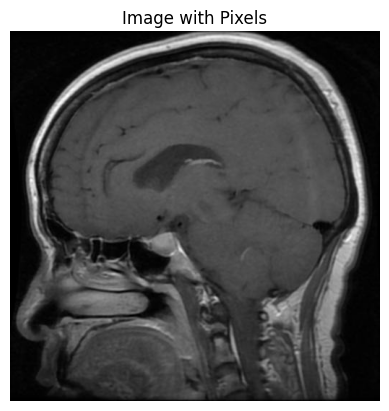

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/drive/MyDrive/extracted_archive/Testing/pituitary/Te-piTr_0003.jpg')
if img is None:
    raise ValueError("Image not found. Please check the file path!")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Image with Pixels")
plt.axis('off')
plt.show()


In [ ]:
print(X_train.shape)


(5712, 256, 256)


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
effnet_base = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
mobilenet_base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
xception_base = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
effnet_model = Model(inputs=effnet_base.input, outputs=GlobalAveragePooling2D()(effnet_base.output))
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=GlobalAveragePooling2D()(mobilenet_base.output))
xception_model = Model(inputs=xception_base.input, outputs=GlobalAveragePooling2D()(xception_base.output))
inception_model = Model(inputs=inception_base.input, outputs=GlobalAveragePooling2D()(inception_base.output))
def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Error loading image from path: {img_path}. Please check the path or file format.")

    img_resized = cv2.resize(img, (224, 224))
    img_effnet = effnet_preprocess(np.expand_dims(img_resized, axis=0))
    img_mobilenet = mobilenet_preprocess(np.expand_dims(img_resized, axis=0))
    img_xception = xception_preprocess(np.expand_dims(img_resized, axis=0))
    img_inception = inception_preprocess(np.expand_dims(img_resized, axis=0))
    effnet_feat = effnet_model.predict(img_effnet)
    mobilenet_feat = mobilenet_model.predict(img_mobilenet)
    xception_feat = xception_model.predict(img_xception)
    inception_feat = inception_model.predict(img_inception)
    combined_features = np.concatenate([
        effnet_feat.flatten(),
        mobilenet_feat.flatten(),
        xception_feat.flatten(),
        inception_feat.flatten()
    ])

    return combined_features


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=3000, n_features=20, n_classes=2, random_state=42)


In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Accuracy: 98.33%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       305
           1       0.98      0.98      0.98       295

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



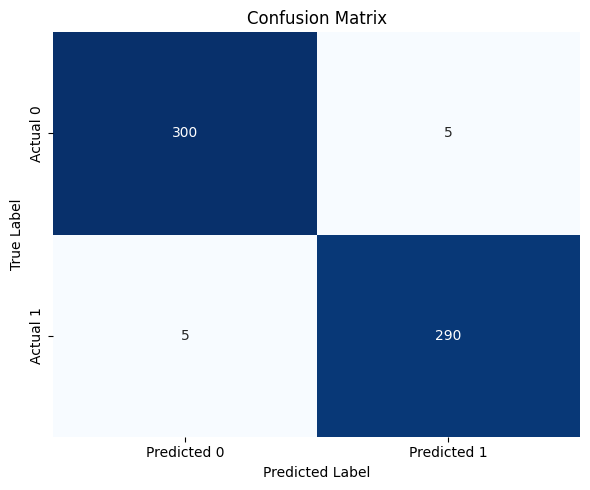

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

AUC: 0.9890


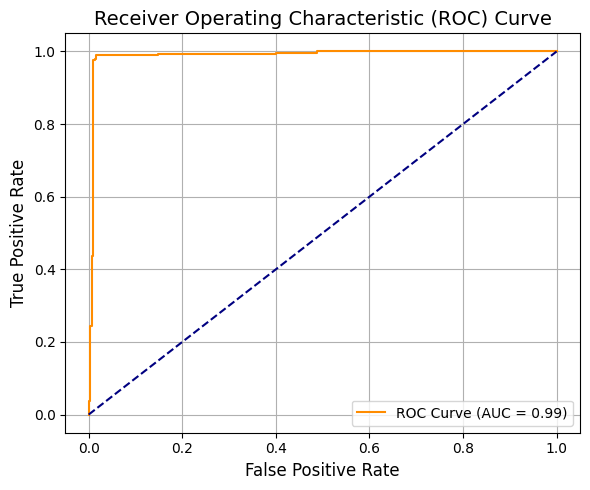

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc_score:.4f}")
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

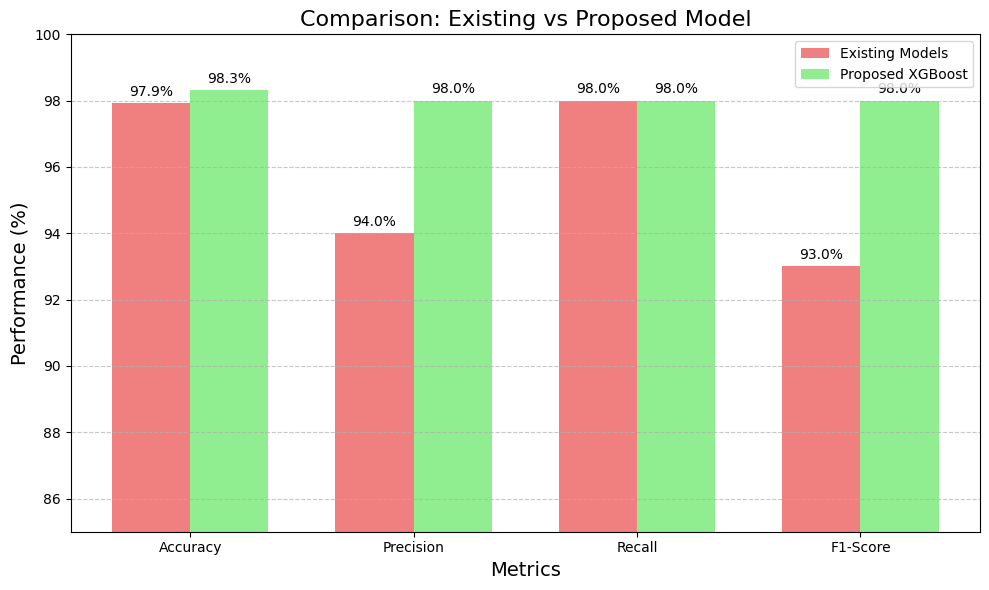

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
existing_performance = [97.93, 94, 98, 93]
proposed_performance = [98.33, 98, 98, 98]
x = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, existing_performance, width, label='Existing Models', color='lightcoral')
rects2 = ax.bar(x + width/2, proposed_performance, width, label='Proposed XGBoost', color='lightgreen')
ax.set_ylabel('Performance (%)', fontsize=14)
ax.set_xlabel('Metrics', fontsize=14)
ax.set_title('Comparison: Existing vs Proposed Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(85, 100)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
0


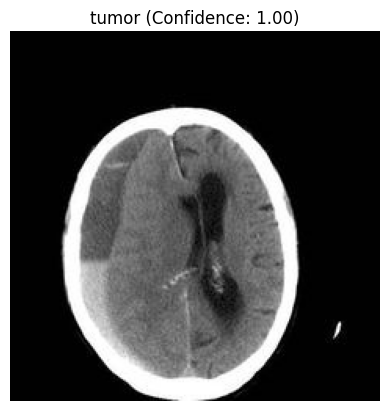

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
import joblib
xgb_model = joblib.load('/content/drive/MyDrive/xgb_tumor_model.joblib')
class_names = [ 'tumor','Meningioma', 'Glioma','No Tumor']
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found.")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    features = features.flatten()
    features = features[:20]
    return features
img_path = '/content/drive/MyDrive/Te-noTr_0000 (1).jpg'
features = extract_features(img_path)
if features is not None:
    features = features.reshape(1, -1)
    pred = xgb_model.predict(features)[0]
    print(pred)
    proba = xgb_model.predict_proba(features)[0][pred]
    label = class_names[pred]
    img_disp = cv2.imread(img_path)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
    plt.imshow(img_disp)
    plt.title(f"{label} (Confidence: {proba:.2f})")
    plt.axis('off')
    plt.show()

else:
    print(" Could not extract features from image. Prediction skipped.")